In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio

import imageio
from PIL import Image, ImageSequence
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_dilation, grey_dilation
from skimage.feature import canny
import skimage.measure as measure
import cv2

In [2]:
import sys
sys.path.append('../src')
from image_segmentation import *

In [3]:
# load all pages of tiff file
tiff_dir = '../data/15052019_algMono0.1_20190517_tiff/'
path = tiff_dir + os.listdir(tiff_dir)[4]
all_pages = open_tiff(path)

In [4]:
path

'../data/15052019_algMono0.1_20190517_tiff/pos10_PH.tiff'

#### Chamber detection for first image

In [5]:
# scale pixel-values
img = all_pages[0]
img = scale_pixel_vals(img)

In [6]:
#image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = img.astype('uint8')
enhanced = cv2.equalizeHist(img)

In [7]:
# apply dilation and find contours at a constant value
# automatic detection of color value
#dilation = grey_dilation(enhanced, size=(20,20)) #size=(20,20)
contours = measure.find_contours(enhanced, 180, fully_connected='high')

In [8]:
# closed_shape_ix = np.where([(c[:,1][0] == c[:,1][-1])&(c[:,0][0] == c[:,0][-1])\
#                             for c in contours])[0]
# closed_shapes = [contours[ix] for ix in closed_shape_ix]

# #find the rectangular contour
# x_range_contours = np.array([np.max(c[:,1]) - np.min(c[:,1]) for c in closed_shapes])
# y_range_contours = np.array([np.max(c[:,0]) - np.min(c[:,0]) for c in closed_shapes])

# #assume chamber size is above a specific value
# ix = list(set(np.where(x_range_contours > 400)[0])&set(np.where(y_range_contours > 400)[0]))

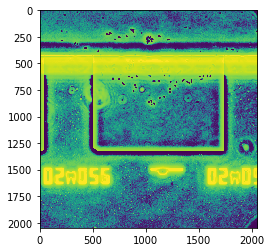

In [9]:
#plt.imshow(dilation)
#plt.plot(np.sum(dilation, axis = 1))
plt.imshow(enhanced)

In [10]:
# compute the range in x-direction for every contour and check for contours above a specific size
ix_rect = find_rectangle(contours, 700, 500)

In [11]:
# get the corners of the rectangle
corners = get_corners(contours[ix_rect])
rectangle_x, rectangle_y, range_x, range_y = draw_rectangle(corners)

corners_cut = get_corners(np.array([rectangle_y, rectangle_x]).T)
cutout = do_cutout(img, corners_cut)

Text(0.5,1,'Cutout')

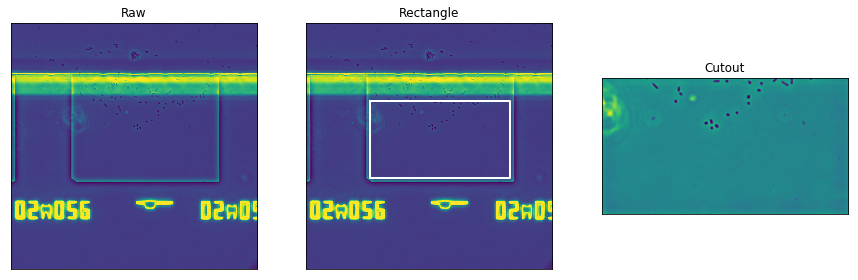

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Raw')
plt.subplot(1,3,2)
plt.imshow(img)
plt.plot(rectangle_x, rectangle_y, 'w', linewidth = 2)
plt.xticks([])
plt.yticks([])
plt.title('Rectangle')
plt.subplot(1,3,3)
plt.imshow(cutout)
plt.xticks([])
plt.yticks([])
plt.title('Cutout')

#### Chamber detection for all following images

In [13]:
# rescale pixel-values
img = all_pages[186]
img = scale_pixel_vals(img)

In [14]:
img = img.astype('uint8')
enhanced = cv2.equalizeHist(img)

In [15]:
# apply dilation and find contours at a constant value
# automatic detection of color value
#dilation = grey_dilation(enhanced, size=(20,20))
contours = measure.find_contours(enhanced, 180, fully_connected='high')

In [16]:
# x_range_contours = np.array([c[:,1] for c in contours])

# closed_rectangle_ix = np.where([c[:,1][0] == c[:,1][-1] for c in contours])[0]
# closed_rectangles = [contours[ix] for ix in closed_rectangle_ix]

# len(closed_rectangles)

In [17]:
# x_val = contours[40][:,1]
# #len(np.where(x_val == 0)[0])
# x_min_val = 0
# x_max_val = img.shape[0]
# y_min_val = 0
# y_max_val = img.shape[1]

In [18]:
# ix = 13
# plt.plot(contours[ix][:,1], contours[ix][:,0])
# (contours[ix][:,1][0] == contours[ix][:,1][-1])&(contours[ix][:,0][0] == contours[ix][:,0][-1])

In [19]:
# compute the range in x-direction for every contour and check for contours above a specific size
ix_rect = find_rectangle(contours, 700, 300)

In [20]:
# get the corners of the rectangle
corners = get_corners(contours[ix_rect])
rectangle_x, rectangle_y = draw_rectangle(corners, range_x, 
                                          range_y, first_image = False)
corners_cut = get_corners(np.array([rectangle_y, rectangle_x]).T)
cutout = do_cutout(img, corners_cut)

Text(0.5,1,'Cutout')

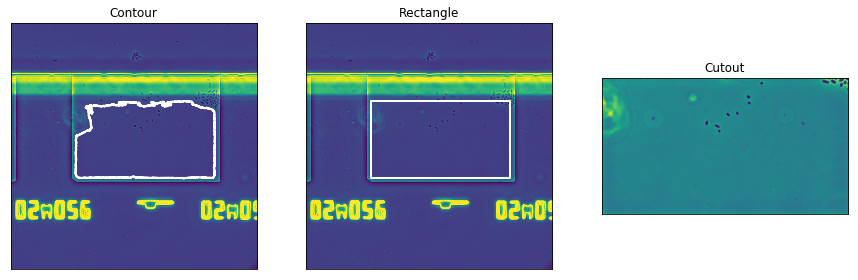

In [21]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Contour')
plt.plot(contours[ix_rect][:,1], contours[ix_rect][:,0], 'w', linewidth = 2)
plt.subplot(1,3,2)
plt.imshow(img)
plt.plot(rectangle_x, rectangle_y, 'w', linewidth = 2)
plt.xticks([])
plt.yticks([])
plt.title('Rectangle')
plt.subplot(1,3,3)
plt.imshow(cutout)
plt.xticks([])
plt.yticks([])
plt.title('Cutout')

#### Cutout all

In [22]:
#path = tiff_dir + os.listdir(tiff_dir)[35]
all_cutouts = cutout_all_pages(path, 700, 200)

100%|██████████| 200/200 [05:02<00:00,  1.36s/it]


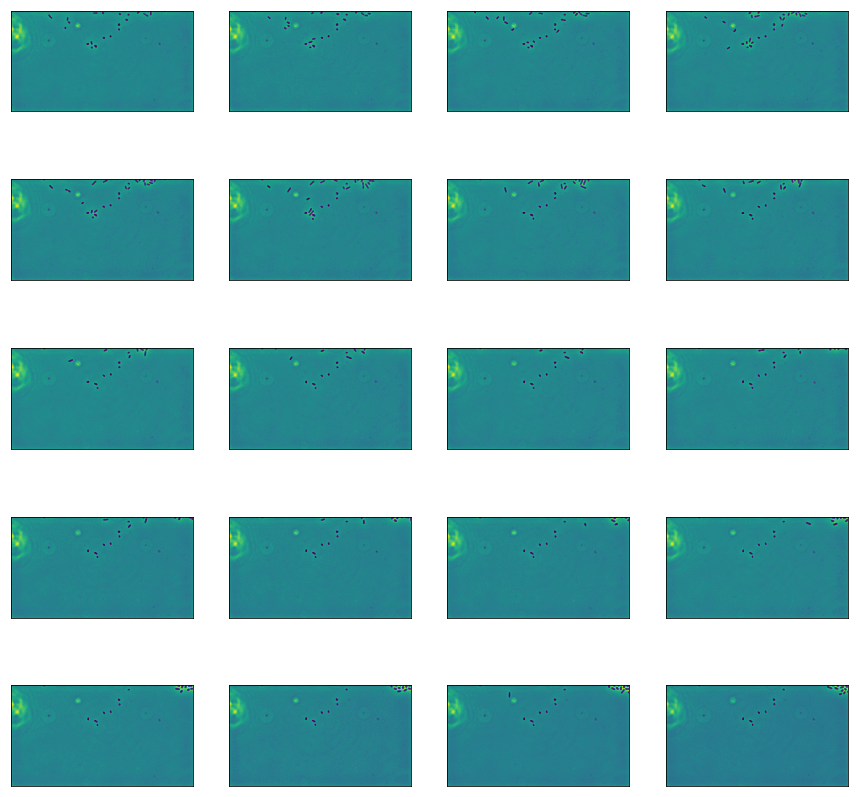

In [23]:
plt.figure(figsize = (15,15))
for i, ac in enumerate(all_cutouts[::10]):
    plt.subplot(5,4,i+1)
    plt.imshow(ac)
    plt.xticks([])
    plt.yticks([])

In [24]:
all_segmentations = []
for data in all_cutouts:
    data = data/np.max(data)
    edges = canny(data)
    all_segmentations.append(ndi.binary_fill_holes(edges))

/cluster/apps/python/3.6.1/x86_64/lib64/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


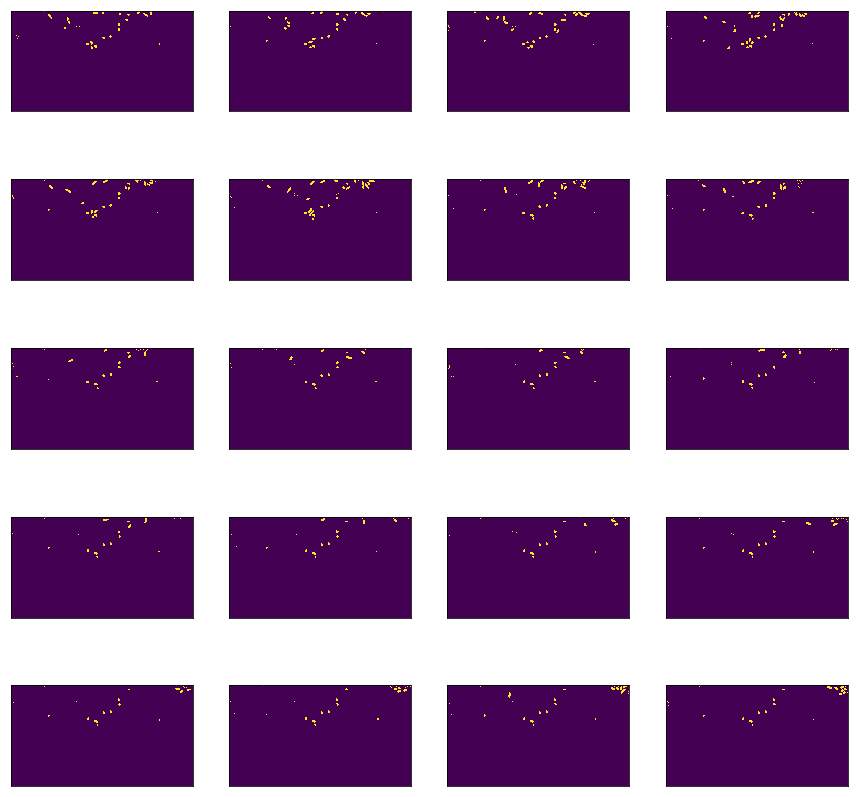

In [25]:
plt.figure(figsize = (15,15))
for i, ac in enumerate(all_segmentations[::10]):
    plt.subplot(5,4,i+1)
    plt.imshow(ac)
    plt.xticks([])
    plt.yticks([])

In [26]:
all_segmentations = [a*1 for a in all_segmentations]

In [27]:
segm_dir = '../data/15052019_algMono0.1_20190517_segm/'
foldername = segm_dir + os.path.splitext(os.path.basename(path))[0] + '.tiff'
imageio.mimwrite(foldername,np.array(all_cutouts))

In [32]:
mname = segm_dir + os.path.splitext(os.path.basename(path))[0]
sio.savemat(mname,{'ar' : np.array(all_cutouts)})